## Part 2 of Project Plant Genes

Based on our feature matrix and plant association results, we built a classifier to determine if a given 
bacterial genome is plant associated, or not.

We first import libraries from scikit-learn, xgboost, and some other libraries to help us determine an optimal model.

In [1]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import svm
from xgboost import XGBClassifier
from sklearn.metrics import mean_absolute_error
import xgboost as xgb

from sklearn.model_selection import RandomizedSearchCV

from scipy import stats

Let's read in the feature matrix, encoding the association in a binary classification format. That means 0 for not plant associated, 1 for plant associated.

In [2]:
feature_matrix = pd.read_pickle('feature_matrix.pkl')
associations = np.array(feature_matrix.iloc[:, -1])
X = feature_matrix.drop('association', axis = 1)
print(X.head())
Y = []
for association in associations:
    if association == "PA":
        Y = Y +[1]
    else:
        Y = Y + [0]

genes       COG0859  COG1032  COG0559  COG1804  COG1492  COG3173  COG0625  \
genomes                                                                     
2505679030      1.0      0.0      0.0      1.0      0.0      1.0      0.0   
651053067       0.0      1.0      1.0      1.0      1.0      1.0      1.0   
637000240       1.0      1.0      1.0      1.0      1.0      1.0      1.0   
637000208       1.0      1.0      1.0      1.0      1.0      1.0      1.0   
650716076       1.0      0.0      1.0      1.0      1.0      1.0      1.0   

genes       COG1638  COG1523  COG3959  ...  COG2732  COG4324  COG4825  \
genomes                                ...                              
2505679030      0.0      0.0      1.0  ...      0.0      1.0      0.0   
651053067       1.0      1.0      1.0  ...      0.0      0.0      0.0   
637000240       1.0      1.0      0.0  ...      0.0      0.0      0.0   
637000208       1.0      0.0      1.0  ...      0.0      1.0      0.0   
650716076       0.0   

Split the dataset into train and test sets. This dataset is not stratified.

In [3]:
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size = 0.2)

Let us fit our data to Random Forest, Support Vector Machine, and XGB Classifier models. We express the accuracy using a balanced accuracy metric, balancing the accuracy to account for the occurence of each class.

In [4]:
rf = RandomForestClassifier(n_estimators = 20)
rf.fit(x_train, y_train)
rf_preds = rf.predict(x_test)
print('Random Forest balanced accuracy: ', metrics.balanced_accuracy_score(y_test, rf_preds))

vm = svm.SVC(kernel = 'linear', probability = True)
vm.fit(x_train,y_train)
svm_preds = vm.predict(x_test)
print('SVM balanced accuracy: ', metrics.balanced_accuracy_score(y_test, svm_preds))

x_model = XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10, n_jobs = 20)
x_model.fit(x_train,y_train)
xgb_preds = x_model.predict(x_test)
print('XGB balanced accuracy: ', metrics.balanced_accuracy_score(y_test, xgb_preds))


Random Forest balanced accuracy:  0.8463760504201681
SVM balanced accuracy:  0.8395483193277311
XGB balanced accuracy:  0.8071165966386555


The majority of the associations are non-plant associated. Let us use this as a baseline model to evaluate our test set compared to our models above.

In [5]:
y_baseline = [0]*len(y_test)
print("Baseline Accuracy: ", metrics.balanced_accuracy_score(y_test, y_baseline))

Baseline Accuracy:  0.5


As expected, our models are better, but still not great. We generate confusion matrices and classification reports for each, to see where the model is not performing as well.

In [6]:
print("=== Confusion Matrix for Random Forest ===")
print(confusion_matrix(y_test, rf_preds))
print("=== Classification Report for Random Forest ===")
print(classification_report(y_test, rf_preds))

print("=== Confusion Matrix for SVM ===")
print(confusion_matrix(y_test, svm_preds))
print("=== Classification Report for SVM ===")
print(classification_report(y_test, svm_preds))

print("=== Confusion Matrix for XGB ===")
print(confusion_matrix(y_test, xgb_preds))
print("=== Classification Report for XGB ===")
print(classification_report(y_test, xgb_preds))

=== Confusion Matrix for Random Forest ===
[[508  36]
 [ 54 170]]
=== Classification Report for Random Forest ===
              precision    recall  f1-score   support

           0       0.90      0.93      0.92       544
           1       0.83      0.76      0.79       224

    accuracy                           0.88       768
   macro avg       0.86      0.85      0.85       768
weighted avg       0.88      0.88      0.88       768

=== Confusion Matrix for SVM ===
[[486  58]
 [ 48 176]]
=== Classification Report for SVM ===
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       544
           1       0.75      0.79      0.77       224

    accuracy                           0.86       768
   macro avg       0.83      0.84      0.84       768
weighted avg       0.86      0.86      0.86       768

=== Confusion Matrix for XGB ===
[[509  35]
 [ 72 152]]
=== Classification Report for XGB ===
              precision    recall  f1-score 

Let us perform hyperparameter optimization using randomized grid search on our models.
We initialize a range of hyperparameters and sample different combinations. We follow with cross validation to determine the overall best model, measuring the balanced accuracy over all hyperparameter combinations and all folds.

In [7]:
from sklearn.model_selection import StratifiedKFold

rand_params= {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'min_samples_split': [2, 5, 10],
 'max_leaf_nodes': [5, 20, 40, 80],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'n_estimators': [5,10,20,30,50,80,100]}
print(rf.get_params())

seed = 7
kfold = StratifiedKFold(n_splits=5, shuffle = True, random_state=seed)
# Sample 20 distributions of the defined hyperparameters
random_search = RandomizedSearchCV(rf, param_distributions = rand_params, n_iter = 20, random_state = 7, 
                                   cv = kfold, scoring = 'balanced_accuracy')
random_search.fit(x_train,y_train)
print(random_search.cv_results_['mean_test_score'].max(), 'is the overall accuracy for an optimized Random Forest')
rf = random_search.best_estimator_


{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 20, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
0.8274055397633155 is the overall accuracy for an optimized Random Forest


Repeat hyperparameter optimization on SVM and update the model to the best parameters.

In [30]:
svm_params = {"C": stats.uniform(2, 10),
             "gamma": stats.uniform(0.1, 1)}
svm_search = RandomizedSearchCV(vm, param_distributions = svm_params, n_iter = 5, random_state = 7,
                                   scoring = 'balanced_accuracy', cv = kfold)
svm_search.fit(x_train,y_train)
print(svm_search.cv_results_['mean_test_score'].max(), 'is the overall accuracy for an optimized SVM')
vm = svm_search.best_estimator_

0.8282472160809462 is the overall accuracy for an optimized SVM


Lastly perform randomized search on XGBoost parameters.

In [8]:
x_params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }
x_search = RandomizedSearchCV(x_model, param_distributions = x_params, n_iter = 20, random_state = 7,
                                   scoring = 'balanced_accuracy', cv = kfold)
x_search.fit(x_train,y_train)
print(x_search.cv_results_['mean_test_score'].max(), 'is the overall accuracy for an optimized XGBoost model')

0.8155604231405519 is the overall accuracy for an optimized XGBoost model


Let's generate the balanced accuracy, confusion matrices, and classification reports for our classifiers on our test data.

In [11]:
x_model = XGBClassifier(params = x_search.best_estimator_.get_params())
x_model.fit(x_train,y_train)
xgb_pred = x_model.predict(x_test)

print("Balanced Accuracy of XGB: ", metrics.balanced_accuracy_score(y_test, xgb_pred))
print("=== Confusion Matrix for XGB ===")
print(confusion_matrix(y_test, xgb_pred))
print("=== Classification Report for XGB ===")
print(classification_report(y_test, xgb_pred))

Balanced Accuracy of XGB:  0.8566176470588236
=== Confusion Matrix for XGB ===
[[507  37]
 [ 49 175]]
=== Classification Report for XGB ===
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       544
           1       0.83      0.78      0.80       224

    accuracy                           0.89       768
   macro avg       0.87      0.86      0.86       768
weighted avg       0.89      0.89      0.89       768



In [31]:
rf = RandomForestClassifier(**random_search.best_estimator_.get_params())
rf.fit(x_train,y_train)
rf_pred = rf.predict(x_test)
print("Balanced Accuracy for RF:", metrics.balanced_accuracy_score(y_test, rf_pred))
print("=== Confusion Matrix for Random Forest ===")
print(confusion_matrix(y_test, rf_pred))
print("=== Classification Report for Random Forest ===")
print(classification_report(y_test, rf_pred))

vm = svm.SVC(**svm_search.best_estimator_.get_params())
vm.fit(x_train,y_train)
svm_pred = vm.predict(x_test)
print("\n")
print("Balanced Accuracy of SVM: ", metrics.balanced_accuracy_score(y_test, svm_pred))
print("=== Confusion Matrix for SVM ===")
print(confusion_matrix(y_test, svm_pred))
print("=== Classification Report for SVM ===")
print(classification_report(y_test, svm_pred))

Balanced Accuracy for RF: 0.8282563025210083
=== Confusion Matrix for Random Forest ===
[[515  29]
 [ 65 159]]
=== Classification Report for Random Forest ===
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       544
           1       0.85      0.71      0.77       224

    accuracy                           0.88       768
   macro avg       0.87      0.83      0.84       768
weighted avg       0.88      0.88      0.87       768



Balanced Accuracy of SVM:  0.8395483193277311
=== Confusion Matrix for SVM ===
[[486  58]
 [ 48 176]]
=== Classification Report for SVM ===
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       544
           1       0.75      0.79      0.77       224

    accuracy                           0.86       768
   macro avg       0.83      0.84      0.84       768
weighted avg       0.86      0.86      0.86       768



We repeat the process of hyperparameter optimization and cross validation, this time with a neural network implementation in Keras.

In [13]:
import tensorflow as tf
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

Using TensorFlow backend.


We define a function required for the Keras wrapper that initializes a baseline model with 1 fully connected layer.

In [14]:
def create_model(optimizer = 'rmsprop', init_mode = 'normal'):
    baseline = keras.Sequential()
    baseline.add(keras.layers.Dense(64, input_dim = 2518, activation = 'relu', kernel_initializer=init_mode))
    baseline.add(keras.layers.Dense(1, activation='sigmoid',kernel_initializer=init_mode))
    baseline.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return baseline

We initialize a baseline model with arbitrary number of epochs.

In [15]:
k_model = KerasClassifier(build_fn = create_model, epochs = 5)

We define a grid of hyperparameters to iterate through to get our optimal hyperparameters.

In [16]:
epochs=[10, 20, 30, 40, 50]
batch_size= [5, 10, 20]
param_grid = dict(epochs = epochs, batch_size = batch_size)

We shuffle our training dataset and use that to optimize our hyperparameters.

In [17]:
kfold = StratifiedKFold(n_splits=5, shuffle = True, random_state=seed)
search_keras = RandomizedSearchCV(estimator = k_model, param_distributions = param_grid, n_iter = 5, 
                                   random_state = 7, verbose = 0, cv = kfold)
result = search_keras.fit(x_train,y_train, verbose = 0)

## 5 different hyperparameter combinations, with 5 folds for each on CV

613/613 [==============================] - 0s 237us/sample - loss: 0.6817 - accuracy: 0.8630


Let's see how accurate our best model was, as well as its rate of false positives, false negatives, etc.

In [18]:
print("Best: %f using %s" % (result.best_score_, result.best_params_))
k_model = KerasClassifier(build_fn = create_model, epochs = result.best_params_["epochs"], 
                          batch_size = result.best_params_["batch_size"])
k_model.fit(x_train,y_train)
k_pred = k_model.predict(x_test)
print("Balanced Accuracy of Keras: ", metrics.balanced_accuracy_score(y_test, k_pred))
print("=== Confusion Matrix for Keras ===")
print(confusion_matrix(y_test, k_pred))
print("=== Classification Report for Keras ===")
print(classification_report(y_test, k_pred))

Best: 0.875854 using {'epochs': 30, 'batch_size': 5}
Train on 3069 samples
Epoch 1/30
3069/3069 [==============================] - 2s 736us/sample - loss: 0.3869 - accuracy: 0.8214
Epoch 2/30
3069/3069 [==============================] - 2s 604us/sample - loss: 0.3122 - accuracy: 0.8667
Epoch 3/30
3069/3069 [==============================] - 2s 639us/sample - loss: 0.2923 - accuracy: 0.8736
Epoch 4/30
3069/3069 [==============================] - 2s 576us/sample - loss: 0.2658 - accuracy: 0.8902
Epoch 5/30
3069/3069 [==============================] - 2s 577us/sample - loss: 0.2460 - accuracy: 0.8983
Epoch 6/30
3069/3069 [==============================] - 2s 540us/sample - loss: 0.2368 - accuracy: 0.9022
Epoch 7/30
3069/3069 [==============================] - 2s 661us/sample - loss: 0.2175 - accuracy: 0.9097
Epoch 8/30
3069/3069 [==============================] - 2s 627us/sample - loss: 0.2036 - accuracy: 0.9202
Epoch 9/30
3069/3069 [==============================] - 2s 622us/sample - los

Let's generate the average accuracy of our model during cross validation on training data.

In [20]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
results = cross_val_score(k_model, x_train, y_train, cv=kfold, verbose = 0)
print(results.mean())
print(results)

Train on 2455 samples
Epoch 1/30
2455/2455 [==============================] - 2s 787us/sample - loss: 0.4032 - accuracy: 0.8196
Epoch 2/30
2455/2455 [==============================] - 1s 465us/sample - loss: 0.3089 - accuracy: 0.8603
Epoch 3/30
2455/2455 [==============================] - 1s 572us/sample - loss: 0.2923 - accuracy: 0.8770
Epoch 4/30
2455/2455 [==============================] - 1s 599us/sample - loss: 0.2632 - accuracy: 0.8904
Epoch 5/30
2455/2455 [==============================] - 1s 545us/sample - loss: 0.2417 - accuracy: 0.9018
Epoch 6/30
2455/2455 [==============================] - 1s 582us/sample - loss: 0.2373 - accuracy: 0.9047
Epoch 7/30
2455/2455 [==============================] - 1s 510us/sample - loss: 0.2107 - accuracy: 0.9193
Epoch 8/30
2455/2455 [==============================] - 1s 455us/sample - loss: 0.2083 - accuracy: 0.9193
Epoch 9/30
2455/2455 [==============================] - 1s 581us/sample - loss: 0.1882 - accuracy: 0.9312
Epoch 10/30
2455/2455 [=

Repeating the process for our cross-validated optimized models, we test the average performance over all folds.

In [21]:
models = [('XGB', x_model), ('RF', rf), ('Keras', k_model),('SVM', vm)]
results = []
seed = 7
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=5, shuffle = True, random_state=seed)
    cv_results = cross_val_score(model, X, Y, cv=kfold, scoring='balanced_accuracy', verbose = 0) 
    results.append(cv_results)
    names.append(name)
    print(name, ' with ', cv_results.mean(), ' ', cv_results.std())

XGB  with  0.8646687846619304   0.017031981302039246
RF  with  0.831109674797139   0.020853577733764096
Train on 3069 samples
Epoch 1/30
3069/3069 [==============================] - 2s 693us/sample - loss: 0.3968 - accuracy: 0.8234
Epoch 2/30
3069/3069 [==============================] - 2s 530us/sample - loss: 0.3081 - accuracy: 0.8658
Epoch 3/30
3069/3069 [==============================] - 2s 649us/sample - loss: 0.2826 - accuracy: 0.8739
Epoch 4/30
3069/3069 [==============================] - 2s 740us/sample - loss: 0.2579 - accuracy: 0.8886
Epoch 5/30
3069/3069 [==============================] - 2s 611us/sample - loss: 0.2480 - accuracy: 0.8993
Epoch 6/30
3069/3069 [==============================] - 2s 658us/sample - loss: 0.2329 - accuracy: 0.9045
Epoch 7/30
3069/3069 [==============================] - 2s 658us/sample - loss: 0.2221 - accuracy: 0.9130
Epoch 8/30
3069/3069 [==============================] - 2s 607us/sample - loss: 0.2073 - accuracy: 0.9182
Epoch 9/30
3069/3069 [====

We can plot the results in a boxplot, to compare the average performance of all the different algorithms.

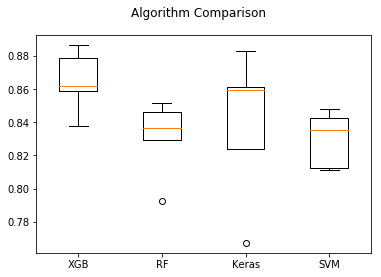

In [22]:
from matplotlib import pyplot
# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

Let's compute the ROC curve for each model. We first predict the probability of each sample belonging to the positive class. Then, we compute the false positive and true positive rate to evaluate our classification cutoff. In other words, we want to maximize the area under the curve, or the ratio of true positives to false positives.

Train on 3069 samples
Epoch 1/30
3069/3069 [==============================] - 3s 821us/sample - loss: 0.3989 - accuracy: 0.8126
Epoch 2/30
3069/3069 [==============================] - 1s 486us/sample - loss: 0.3075 - accuracy: 0.8684
Epoch 3/30
3069/3069 [==============================] - 1s 463us/sample - loss: 0.2926 - accuracy: 0.8755
Epoch 4/30
3069/3069 [==============================] - 2s 615us/sample - loss: 0.2633 - accuracy: 0.8905
Epoch 5/30
3069/3069 [==============================] - 2s 644us/sample - loss: 0.2458 - accuracy: 0.8961
Epoch 6/30
3069/3069 [==============================] - 2s 608us/sample - loss: 0.2264 - accuracy: 0.9042
Epoch 7/30
3069/3069 [==============================] - 2s 497us/sample - loss: 0.2150 - accuracy: 0.9117
Epoch 8/30
3069/3069 [==============================] - 2s 556us/sample - loss: 0.2065 - accuracy: 0.9156
Epoch 9/30
3069/3069 [==============================] - 2s 556us/sample - loss: 0.1931 - accuracy: 0.9257
Epoch 10/30
3069/3069 [=

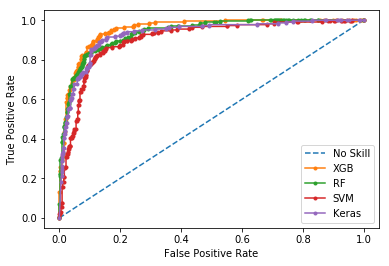

In [23]:
from matplotlib import pyplot
from sklearn.metrics import roc_curve

k_model.fit(x_train,y_train)
x_model.fit(x_train,y_train)
rf.fit(x_train,y_train)
vm.fit(x_train,y_train)

xgb_preds = x_model.predict(x_test)
xprobs = x_model.predict_proba(x_test)[:,1]


svm_probs = vm.predict_proba(x_test)[:,1]
k_probs = k_model.predict_proba(x_test)[:,1]
rf_probs = rf.predict_proba(x_test)[:,1]

#baseline no skill plot
pyplot.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
fpr, tpr, threshold = roc_curve(y_test, xprobs)
pyplot.plot(fpr, tpr, marker='.', label='XGB')
fpr, tpr, threshold = roc_curve(y_test, rf_probs)
pyplot.plot(fpr, tpr, marker='.', label='RF')
fpr, tpr, threshold = roc_curve(y_test, svm_probs)
pyplot.plot(fpr, tpr, marker='.', label='SVM')
fpr, tpr, threshold = roc_curve(y_test, k_probs)
pyplot.plot(fpr, tpr, marker='.', label='Keras')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

Lastly let's finish off with a precision recall curve, using the probabilities computed earlier. This time, our baseline is the proportion of the dataset which is positive (1-1 recall to precision ratio). Our precision recall curve measures the tradeoff between the ratio of those correctly classified as positive vs all actual positives, to those classified correctly as positive, over everything that has been classified as positive. In other words, the susceptibility to false positives compared to false negatives.

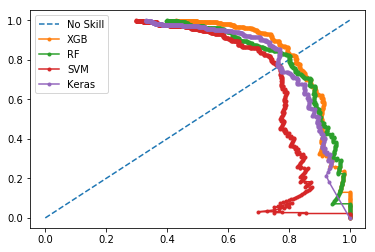

In [29]:
from sklearn.metrics import precision_recall_curve
ones = np.asarray(Y)
baseline = len(ones[ones==1])/ len(Y)
pyplot.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
fpr, tpr, threshold = precision_recall_curve(y_test, xprobs)
pyplot.plot(fpr, tpr, marker='.', label='XGB')
fpr, tpr, threshold = precision_recall_curve(y_test, rf_probs)
pyplot.plot(fpr, tpr, marker='.', label='RF')
fpr, tpr, threshold = precision_recall_curve(y_test, svm_probs)
pyplot.plot(fpr, tpr, marker='.', label='SVM')
fpr, tpr, threshold = precision_recall_curve(y_test, k_probs)
pyplot.plot(fpr, tpr, marker='.', label='Keras')
pyplot.legend()

We can see from the above plots that the XGB model is best at optimizing the area under the curve.

1. investigate COG annotations
Cognator pipeline --> used in Levy paper to annotate incoming genomes with cogs
Read into COG annotations with COGsoft

If the gene clusters these bugs have vs if they're plant associated
gene clusters to recognize from the levy data? 

metagenomics, make some more classifiers --> feeds into HPC
2. Read the metagenomic notebook thingy

data visualization? :oo

